# ResNets

This week we discussed ResNets which are convolutional neural networks but with a residual learning framework realized by creating residual blocks via shortcut connections. In this notebook, we'll be implementing a fully connected NN, a plain CNN and a residual network and comparing the results on the MNIST dataset.

We'll start off by loading the data. We'll be working with the MNIST dataset, which provides 70,000 labeled 28x28 images of handwritten digits. Our goal is to construct a classifier that recognizes handwritten digits.

In [296]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms

%matplotlib notebook

# Load the dataset... This can take a while
if("mnist" not in globals()):  # Don't load the dataset twice...
    mnist = fetch_openml('mnist_784', version=1)
    # Convert DataFrame to 24x24 numpy arrays...
    imgs = mnist.data.to_numpy().reshape(70000, 28, 28).astype(np.float32)
    # Labels for the mnist data, 0-9 being the number...
    labels = np.asarray(mnist.target).astype(int)
    
    imgs_train, imgs_test, labels_train, labels_test = train_test_split(
        imgs, labels, test_size=0.2, random_state=1
    )

Let's plot one of the digits at random to see what they look like.

<IPython.core.display.Javascript object>


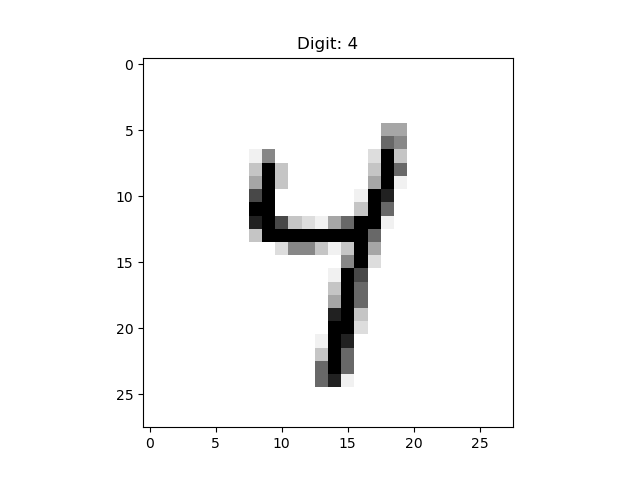

In [298]:
idx = np.random.randint(0, imgs.shape[0])
single_digit = imgs[idx]
single_label = labels[idx]

fig, ax = plt.subplots(1, 1)
ax.set_title(f"Digit: {single_label}")
ax.imshow(single_digit, cmap="Greys")
fig.show()

We'll attempt to use a GPU to run these models. We'll check if one is available and assign it to our device.

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches” and reshuffle the data at every epoch to reduce model overfitting. 

In [4]:
# Set the batch size: (Will be set to None in the final version)
batch_size = 50

# Set up data loaders, these will be used to train and test models...
to_device = lambda a: torch.from_numpy(a).to(device)

train_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_train), to_device(labels_train)),
    batch_size = batch_size,
    shuffle = True
)

test_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_test), to_device(labels_test)),
    batch_size = batch_size,
    shuffle = True
)

## Simple Model: Fully Connected NN

Now that we have our data set-up, let's start to implement our first network: a fully connected neural network.

In [5]:
class SimpleNet(nn.Module):
    def __init__(
        self, 
        img_w: int, 
        img_h: int, 
        hidden_layer_sizes: list, 
        class_size: int
    ):
        super().__init__()
        
        self._in_layer = nn.Linear(img_w * img_h, hidden_layer_sizes[0])
        
        layers = []
        for hls1, hls2 in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([nn.Linear(hls1, hls2), nn.ReLU()])
        
        self._hidden_layers = nn.Sequential(*layers)
        
        self._out_layer = nn.Linear(hidden_layer_sizes[-1], class_size)
        self._softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = x.reshape(-1, img_w * img_h)
        
        x = self._in_layer(x)
        x = self._hidden_layers(x)
        return self._softmax(self._out_layer(x))

Let's define some variables to use with our simple network.

In [6]:
# Set these! (We'll replace these with None in the final version...)
img_w = 28
img_h = 28
hidden_layer_sizes = [1000, 500, 100]  # List of None
class_size = 10

simple_net = SimpleNet(img_w, img_h, hidden_layer_sizes, class_size)
simple_net.to(device)

SimpleNet(
  (_in_layer): Linear(in_features=784, out_features=1000, bias=True)
  (_hidden_layers): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): ReLU()
  )
  (_out_layer): Linear(in_features=100, out_features=10, bias=True)
  (_softmax): Softmax(dim=1)
)

We also want some functions to see how our network performs. These are defined below:

In [92]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs, 
    augment_method=None, 
    print_every=300
):
    for epoch_i in range(1, n_epochs + 1):
        for i, (img, label) in enumerate(train_data, 1):
            model.zero_grad()
            # If an augmentation method is passed, use it before passing the image to the model.
            predicted = model.forward(img if(augment_method is None) else augment_method(img))
            loss = error_func(predicted, label)
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        acc1 = get_accuracy(model, train_data, augment_method)
        print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
        acc2 = get_accuracy(model, test_data, augment_method)
        print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data, im_mod = None):
        run = 0
        correct = 0
        
        for img, label in data:
            img = im_mod(img) if(im_mod is not None) else img   # Allows us to modify the images...
            run += len(img)
            result = model.forward(img).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

Let's set a number of epochs and a learning rate for the model and see how it does.

In [93]:
# Set these! (We'll replace these with None in final version)
n_epochs = 10
lr = 1e-5

# Set up everything...
optimizer = optim.Adam(simple_net.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [94]:
# Train the model...
simple_net = train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs)

Epoch: 1/10, Iter: 300/1120, Loss: 1.6086
Epoch: 1/10, Iter: 600/1120, Loss: 1.5966
Epoch: 1/10, Iter: 900/1120, Loss: 1.5406
Epoch: 1/10, Iter: 1120/1120, Loss: 1.5778
Epoch 1 Train Accuracy: 89.30%
Epoch 1 Test Accuracy: 88.16%

Epoch: 2/10, Iter: 300/1120, Loss: 1.5256
Epoch: 2/10, Iter: 600/1120, Loss: 1.4883
Epoch: 2/10, Iter: 900/1120, Loss: 1.4814
Epoch: 2/10, Iter: 1120/1120, Loss: 1.4952
Epoch 2 Train Accuracy: 98.60%
Epoch 2 Test Accuracy: 96.91%

Epoch: 3/10, Iter: 300/1120, Loss: 1.4923
Epoch: 3/10, Iter: 600/1120, Loss: 1.4856
Epoch: 3/10, Iter: 900/1120, Loss: 1.4814
Epoch: 3/10, Iter: 1120/1120, Loss: 1.4825
Epoch 3 Train Accuracy: 98.91%
Epoch 3 Test Accuracy: 97.18%

Epoch: 4/10, Iter: 300/1120, Loss: 1.4683
Epoch: 4/10, Iter: 600/1120, Loss: 1.4822
Epoch: 4/10, Iter: 900/1120, Loss: 1.4956


KeyboardInterrupt: 

### Is this model robust to translations?

Our initial results are pretty good! Let's see the accuracy when we "shift" the image data around a little bit...

<IPython.core.display.Javascript object>


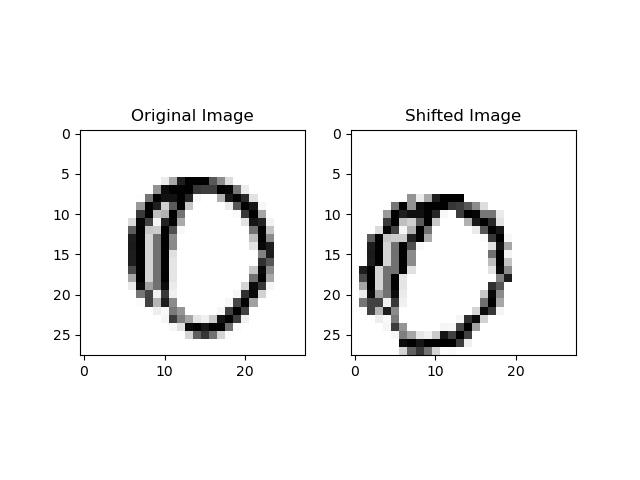

In [301]:
img_transform = transforms.RandomAffine((-10, 10), (0.2, 0.2), (0.8, 1.2), (-5, 5))

def img_shift_and_warp(img: torch.tensor) -> torch.tensor:
    if(len(img.shape) == 2):
        img = img.reshape(1, *img.shape)   
    img = img_transform(img)
    return img
    

# Show what img_shift_and_warp does to our images...
random_idx = np.random.randint(0, len(imgs))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original Image")
ax2.set_title("Shifted Image")
ax1.imshow(imgs[random_idx], cmap="Greys")
ax2.imshow(img_shift_and_warp(torch.from_numpy(imgs[random_idx]))[0], cmap="Greys")

fig.show()

In [97]:
print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 97.48%
Translation Test Accuracy: 52.72%


Yikes! Shifting around the numbers destroys the accuracy of our simple fully connected network destroys its performance. Can we fix this through data augmentation?

In [98]:
# Train the model...
simple_net = train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs, img_shift_and_warp)

Epoch: 1/10, Iter: 300/1120, Loss: 1.6075
Epoch: 1/10, Iter: 600/1120, Loss: 1.9261
Epoch: 1/10, Iter: 900/1120, Loss: 1.5655
Epoch: 1/10, Iter: 1120/1120, Loss: 1.7772
Epoch 1 Train Accuracy: 75.07%
Epoch 1 Test Accuracy: 75.44%

Epoch: 2/10, Iter: 300/1120, Loss: 1.6144
Epoch: 2/10, Iter: 600/1120, Loss: 1.7389
Epoch: 2/10, Iter: 900/1120, Loss: 1.7644
Epoch: 2/10, Iter: 1120/1120, Loss: 1.6081
Epoch 2 Train Accuracy: 79.23%
Epoch 2 Test Accuracy: 79.76%

Epoch: 3/10, Iter: 300/1120, Loss: 1.5838
Epoch: 3/10, Iter: 600/1120, Loss: 1.8157
Epoch: 3/10, Iter: 900/1120, Loss: 1.6141
Epoch: 3/10, Iter: 1120/1120, Loss: 1.5608
Epoch 3 Train Accuracy: 81.74%
Epoch 3 Test Accuracy: 82.81%

Epoch: 4/10, Iter: 300/1120, Loss: 1.7814
Epoch: 4/10, Iter: 600/1120, Loss: 1.6660
Epoch: 4/10, Iter: 900/1120, Loss: 1.5983
Epoch: 4/10, Iter: 1120/1120, Loss: 1.5963
Epoch 4 Train Accuracy: 83.34%
Epoch 4 Test Accuracy: 83.39%

Epoch: 5/10, Iter: 300/1120, Loss: 1.6280
Epoch: 5/10, Iter: 600/1120, Loss:

In [99]:
print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 95.83%
Translation Test Accuracy: 87.81%


Even after training the network using augmented images, we can see that a fully connected network still performs worse on transformed images. Even more interesting, is that the network now performs more poorly on the original data.

### Question

__Why do you think the model performs more poorly on the original data when trained on augmented data?__

# Using a ResNet

Now that we've looked at a fully connected network and a, let's see if we can achieve even better results with a residual network (ResNet).

We'll start by defining a residual block. Let's do a quick recap on what this is.
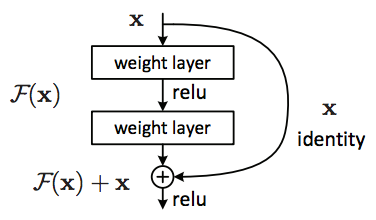
Here we let $H(\textbf{x})$ be the output of a few stacked nonlinear layers where $\textbf{x}$ is the input to the first of these layers. 
We'll let these stacked layers fit a residual mapping (the difference between the input and output) with $F(\textbf{x}) = H(\textbf{x}) - \textbf{x}$.
Our original function now becomes $H(\textbf{x}) = F(\textbf{x}) + \textbf{x}$. We expect this to be easier for the solvers to optimize as opposed to the original unreferenced mapping.

A residual block can be formally defined with the equation
$\textbf{y} = F(\textbf{x}, \{W_{i}\}) + W_s\textbf{x}$ where $\textbf{x}, \textbf{y}$ are the input and output vectors and $F(\textbf{x}, \{W_{i}\})$ is the residual mapping to be learned.
For the example block shown here (what we'll be implementing) with two weight layers and a ReLU function, we let $F = W_2 \sigma (W_1\textbf{x})$

The main thing to takeaway from residual blocks (and what makes ResNets differ from plain CNNs) is the use of the identity shortcut connection which allows the input to be added to the output of the stacked layers.

In [251]:
class ResidualBlock(nn.Module):
    """
    A single residual block.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1):
        super().__init__()
        
        if(kernel_size % 2 == 0):
            raise ValueError("Kernel size must be odd!")
            
        self._in_channels = in_channels
        self._out_channels = out_channels
        
        self._conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self._relu = nn.ReLU()
        self._conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size // 2)
        
        if(stride == 1):
            self._identity = nn.Identity()
        else:
            # As paper suggests use convolution with 1x1 kernel and stride of 2 to linearly downsample the data
            self._identity = nn.Conv2d(in_channels, out_channels, (1, 1), 2)
        
        self._relu2 = nn.ReLU()
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        # Non-Linear part...
        x_nonlinear = self._conv2(self._relu(self._conv1(x)))
        # Linear part...
        x_linear = self._identity(x)
        return self._relu2(x_nonlinear + x_linear)

    
class VanillaBlock(nn.Module):
    """
    A single vanilla block (no skip connections).
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1):
        super().__init__()
        
        if(kernel_size % 2 == 0):
            raise ValueError("Kernel size must be odd!")
            
        self._in_channels = in_channels
        self._out_channels = out_channels
        
        self._conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self._relu = nn.ReLU()
        self._conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size // 2)
        self._relu2 = nn.ReLU()
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        x_nonlinear = self._conv2(self._relu(self._conv1(x)))     
        return self._relu2(x_nonlinear)


Now, we'll define a network capable of taking a layer description list and building a ResNet style CNN out of this list.

In [261]:
class ResNet(nn.Module):
    def __init__(self,
        in_channels: int,
        hidden_size: int, 
        output_size: int,
        start_depth: int = 64
    ):
        super().__init__()
        
        self._output_size = output_size
        
        l_in = start_depth
        
        self._initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, l_in, 7, stride=1, padding=3),  # Modification, remove stride, makes final image too small...
            nn.MaxPool2d(3, 2, padding=1)
        )
        
        # Output dims, kernel size, stride, amount...
        layers = self.get_layers(start_depth)
        
        self._final_layer_len = layers[-1][0]
        
        residual_layers = []
                
        for l_out, kernel, stride, count, block_cls in layers:
            for i in range(count):
                res = block_cls(l_in, l_out, kernel, stride)
                residual_layers.append(res)
            l_in = l_out
        
        self._residual_blocks = nn.Sequential(*residual_layers)
        
        self._final_pooling = nn.AdaptiveAvgPool2d(1)
        
        self._fully_connected = nn.Sequential(
            nn.Linear(self._final_layer_len, hidden_size),
            nn.Linear(hidden_size, output_size)
        )
        self._softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor, run_pooling: bool=True) -> torch.tensor:
        batch_size = x.shape[0]
        
        x = x.reshape(batch_size, 1, *(x.shape[1:]))
        x = self._initial_conv(x)
        x = self._residual_blocks(x)
        
        if(run_pooling):
            x = torch.moveaxis(self._final_pooling(x), 1, -1)
            x = x.reshape(-1, self._final_layer_len)
            return self._softmax(self._fully_connected(x))
        else:
            # No pooling: Run the classifier on every pixel in the image...
            im_shape = x.shape[2:]
            x = torch.moveaxis(x, 1, -1).reshape(-1, self._final_layer_len)
            x = self._fully_connected(x)
            return x.reshape(batch_size, *im_shape, self._output_size)
            
    def get_layers(self, start_depth) -> list:
        raise NotImplementedError("Use one of the ResNet subclasses!")
        

Now we can use this class to define several types of ResNets and regular CNNs

In [302]:
# Layers: A list of tuples which describe the following in order:
# (CNN layer depth, kernel size, stride, number of blocks, block class)
        
class VanillaNet18(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 2, VanillaBlock),
            (l_in * 2, 3, 2, 1, VanillaBlock),
            (l_in * 2, 3, 1, 1, VanillaBlock),
            (l_in * 4, 3, 2, 1, VanillaBlock),
            (l_in * 4, 3, 1, 1, VanillaBlock),
            (l_in * 8, 3, 2, 1, VanillaBlock),
            (l_in * 8, 3, 1, 1, VanillaBlock)
        ]
    
class ResNet18(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 2, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 1, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 1, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 1, ResidualBlock)
        ]
    
class VanillaNet34(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 3, VanillaBlock),
            (l_in * 2, 3, 2, 1, VanillaBlock),
            (l_in * 2, 3, 1, 3, VanillaBlock),
            (l_in * 4, 3, 2, 1, VanillaBlock),
            (l_in * 4, 3, 1, 5, VanillaBlock),
            (l_in * 8, 3, 2, 1, VanillaBlock),
            (l_in * 8, 3, 1, 2, VanillaBlock)
        ]
    
class ResNet34(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 3, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 3, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 5, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 2, ResidualBlock)
        ]

We'll define a new ResNet (or non-ResNet) below.

In [265]:
# What values should be here? (Replace with none in final version)
in_channels = 1
output_size = 10
channel_start = 64
hidden_layer_size = 1000
model_class = ResNet34


res_net = model_class(in_channels, hidden_layer_size, output_size, channel_start)
res_net.to(device)

ResNet34(
  (_initial_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (_residual_blocks): Sequential(
    (0): ResidualBlock(
      (_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity()
      (_relu2): ReLU()
    )
    (1): ResidualBlock(
      (_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity()
      (_relu2): ReLU()
    )
    (2): ResidualBlock(
      (_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identit

Now we can train the ResNet using the same methods as the simple model above.

In [266]:
# Set these! (We'll replace these with None in final version)
n_epochs2 = 10
lr2 = 0.001

# Set up everything...
optimizer2 = optim.SGD(res_net.parameters(), lr=lr2, momentum=0.9)
loss_func2 = nn.CrossEntropyLoss()

In [267]:
# Train the model...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2)

Epoch: 1/10, Iter: 300/1120, Loss: 2.0129
Epoch: 1/10, Iter: 600/1120, Loss: 1.7639
Epoch: 1/10, Iter: 900/1120, Loss: 1.6646
Epoch: 1/10, Iter: 1120/1120, Loss: 1.5437
Epoch 1 Train Accuracy: 84.97%
Epoch 1 Test Accuracy: 84.91%

Epoch: 2/10, Iter: 300/1120, Loss: 1.6720
Epoch: 2/10, Iter: 600/1120, Loss: 1.5808
Epoch: 2/10, Iter: 900/1120, Loss: 1.5641
Epoch: 2/10, Iter: 1120/1120, Loss: 1.6456
Epoch 2 Train Accuracy: 87.22%
Epoch 2 Test Accuracy: 87.06%

Epoch: 3/10, Iter: 300/1120, Loss: 1.5928
Epoch: 3/10, Iter: 600/1120, Loss: 1.5930
Epoch: 3/10, Iter: 900/1120, Loss: 1.5813
Epoch: 3/10, Iter: 1120/1120, Loss: 1.5999
Epoch 3 Train Accuracy: 88.02%
Epoch 3 Test Accuracy: 88.01%

Epoch: 4/10, Iter: 300/1120, Loss: 1.6508
Epoch: 4/10, Iter: 600/1120, Loss: 1.5501
Epoch: 4/10, Iter: 900/1120, Loss: 1.5472
Epoch: 4/10, Iter: 1120/1120, Loss: 1.5241
Epoch 4 Train Accuracy: 88.72%
Epoch 4 Test Accuracy: 88.62%

Epoch: 5/10, Iter: 300/1120, Loss: 1.6657
Epoch: 5/10, Iter: 600/1120, Loss:

KeyboardInterrupt: 

Let's see how this model performs on augmented data.

In [268]:
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 89.03%
Translation Test Accuracy: 38.78%


The model still performs poorly, but can we achieve better performance by training on the randomly augmented data?

In [269]:
# Retrain using image warping...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, img_shift_and_warp)

Epoch: 1/10, Iter: 300/1120, Loss: 1.9421
Epoch: 1/10, Iter: 600/1120, Loss: 2.0274
Epoch: 1/10, Iter: 900/1120, Loss: 1.7036
Epoch: 1/10, Iter: 1120/1120, Loss: 1.6049
Epoch 1 Train Accuracy: 80.93%
Epoch 1 Test Accuracy: 81.73%

Epoch: 2/10, Iter: 300/1120, Loss: 1.5583
Epoch: 2/10, Iter: 600/1120, Loss: 1.7752
Epoch: 2/10, Iter: 900/1120, Loss: 1.6527
Epoch: 2/10, Iter: 1120/1120, Loss: 1.5839
Epoch 2 Train Accuracy: 82.93%
Epoch 2 Test Accuracy: 83.37%

Epoch: 3/10, Iter: 300/1120, Loss: 1.6731
Epoch: 3/10, Iter: 600/1120, Loss: 1.6770
Epoch: 3/10, Iter: 900/1120, Loss: 1.6117
Epoch: 3/10, Iter: 1120/1120, Loss: 1.5872
Epoch 3 Train Accuracy: 85.78%
Epoch 3 Test Accuracy: 85.68%

Epoch: 4/10, Iter: 300/1120, Loss: 1.5806
Epoch: 4/10, Iter: 600/1120, Loss: 1.6009
Epoch: 4/10, Iter: 900/1120, Loss: 1.6137
Epoch: 4/10, Iter: 1120/1120, Loss: 1.6109
Epoch 4 Train Accuracy: 86.57%
Epoch 4 Test Accuracy: 86.85%

Epoch: 5/10, Iter: 300/1120, Loss: 1.5816
Epoch: 5/10, Iter: 600/1120, Loss:

In [270]:
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(res_net, test_loader, img_shift_and_warp) * 100:.02f}%")

Normal Test Accuracy: 97.91%
Translation Test Accuracy: 96.19%


### Questions

__What results do you get using the ResNet? How do these differ from the simple fully connected network, and why do you think the results differ?__

__Try experimenting with different models above (including non-residual CNNs). How do your results differ from the regular ResNet?__

### Bonus Exercise: Localized Results

You may wonder if the CNN is not only able to tell us what digit we're looking at, but also where it is located. We can test if the CNN is providing localized results by removing the final average pooling layer, and applying the fully connected layers on every pixel instead of on the average of the pixels. We'll also pass the CNN an image with multiple numbers, to see if it is capable of identifying several numbers across the image.

__What results do you observe below? Is the ResNet able to provide localized results?__

<IPython.core.display.Javascript object>


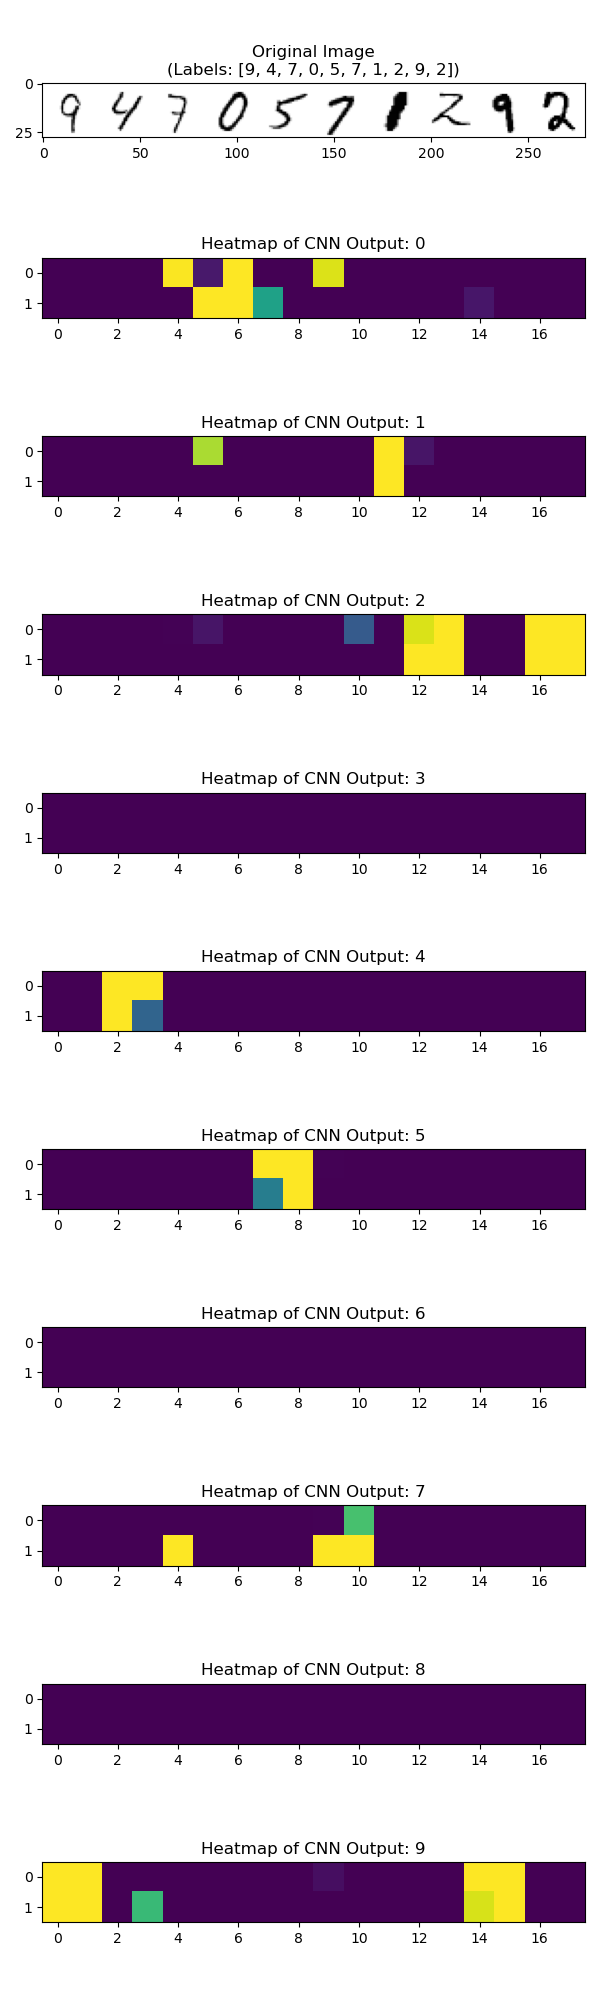

In [304]:
for img, label in train_loader:
    fig = plt.figure(figsize=(6, 20))
    axs = fig.subplots(11, 1)
    
    ax1, axs = axs[0], axs[1:]
    
    # Take the first set of numbers...
    num_nums = min(batch_size, 10)
    
    img = torch.cat([p for p in img[:num_nums]], dim=1)
    
    # Network doesn't apply the softmax when we disable pooling, so we apply it here.
    # This places all the scores between 0 and 1, and emphasises the highest score. 
    single_res_grid = torch.softmax(res_net.forward(img.reshape(1, 28, num_nums * 28), False), -1)[0]
    
    ax1.imshow(img.cpu().detach().numpy(), cmap="Greys")
    ax1.set_title(f"Original Image\n(Labels: {[int(l) for l in label[:num_nums]]})")
    
    for i, ax in enumerate(axs):
        ax.set_title(f"Heatmap of CNN Output: {i}")
        total_len = single_res_grid[:, :, i]
        ax.imshow(single_res_grid[:, :, i].cpu().detach().numpy(), vmin=0, vmax=1)
    
    fig.tight_layout()
    fig.show()
    
    break